In [1]:
# import required modules
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

#### Split data into two datasets (training and test)

In [2]:
# Set seed
np.random.seed(1234)

# read in data
turnout_data = pd.read_csv("turnout.csv")

# Train-Test split
train = turnout_data.sample(frac=.8).reset_index(drop=True)
test = turnout_data.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,id,age,educate,income,vote,white
0,1749,78,16.0,1.3131,1,1
1,935,72,3.0,0.6765,1,0
2,1034,64,10.0,1.3131,1,1
3,244,80,8.0,1.1839,1,1
4,929,19,14.0,2.9072,1,1


In [3]:
# subset data
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

#### Calculate class probabilities, and conditional probabilities (for binary predictors)



In [4]:
# Caluclate and store class probabilites and conditional probabilities of binary predictors into dictionaries
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    Parameters:
    data: dataframe containing outcome variable and predictors
    outcome_var (str): outcome variable i.e. what we want to predict
    
    Output:
    class_probs (dict): dictionary item containing class probabilities 
    cond_probs (dict): dictionary item containing conditional probabilities
    '''
    
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v == "white"]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs


# Run function and store output in variables
class_probs, cond_probs = calc_probs(train,outcome_var="vote")

# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.2575, 1: 0.7425}


conditional probabilities

{('white', 0, 0): 0.20145631067961167,
 ('white', 0, 1): 0.13131313131313127,
 ('white', 1, 0): 0.7985436893203883,
 ('white', 1, 1): 0.8686868686868687}


#### Calculate conditional probabilities (for continuous predictors)

In [5]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853716},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('income', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('income', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964}}


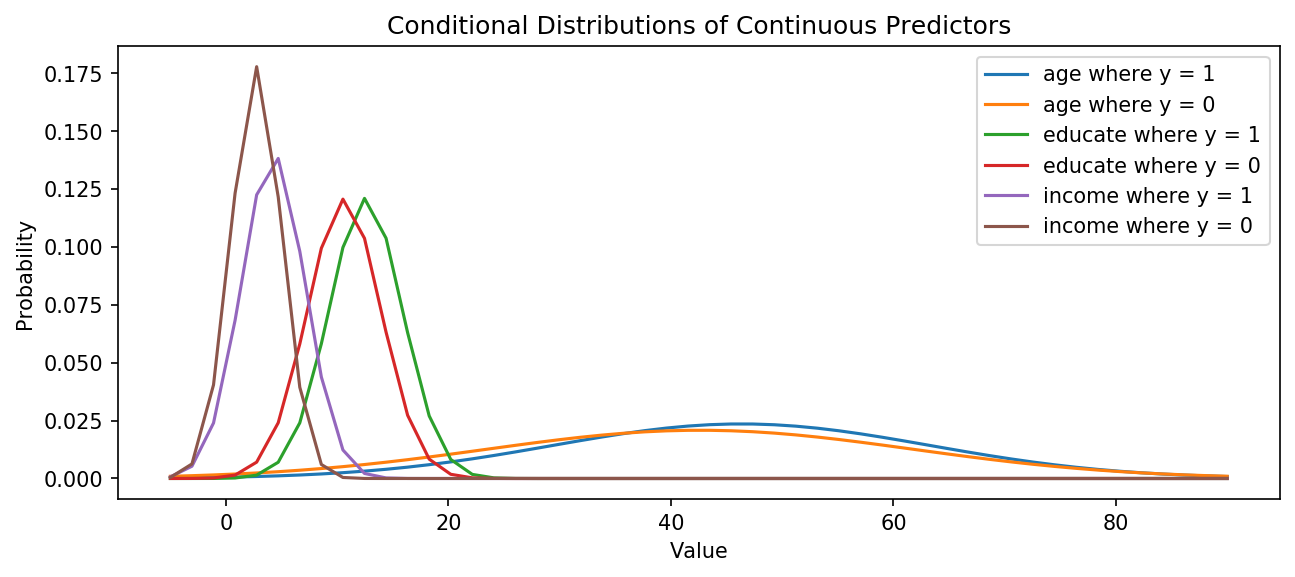

In [6]:
# plot conditional distributions
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-5,90)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")
    ax.set_title("Conditional Distributions of Continuous Predictors")
    ax.set(xlabel="Value",ylabel="Probability")

#### Make predictions

In [7]:
def predict(data,class_probs,cond_probs,dist_locs):
    '''
    Function calculates the conditional probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    
    Parameters:
    data: data frame
    class_probs (dict): dictionary item containing class probabilites
    cond_probs (dict): dictionary item containing conditional probabilities of binary predictors
    dist_locs (dict): dictionary item containing the mean and standard dev. of each conditional distribution
    
    Output:
    data frame containing probabilities and the most likely class.
    '''
    
    # create list to store predictions
    store_preds = []
    
    # iterate through data
    for i,row in data.iterrows():
        
        # set probabilities = 1 to 
        pr_vote1 = 1; pr_vote0 = 1
        
        for j in row.index:
            if (j=='vote') or (j=='id'):
                continue
            elif j == 'white':
                pr_vote0 *= cond_probs[(j,row[j],0)] 
                pr_vote1 *= cond_probs[(j,row[j],1)]
            else:
                pr_vote0 *= st.norm(dist_locs[(j,0)]['mean'], dist_locs[(j,0)]['sd']).pdf(row[j])
                pr_vote1 *= st.norm(dist_locs[(j,1)]['mean'], dist_locs[(j,1)]['sd']).pdf(row[j])
        
        # Multiply with class probabilities
        pr_vote0 *= class_probs[0]
        pr_vote1 *= class_probs[1]
        
        # Assign the class designation to the highest probability
        if pr_vote0 >= pr_vote1:
            class_pred = 0
        else:
            class_pred = 1
        
        # Store probabilities and predicted outcomes 
        store_preds.append([pr_vote0,pr_vote1,class_pred])
        
    # return data frame    
    return pd.DataFrame(store_preds,columns=["pr_vote0","pr_vote1","pred"])

# Run function
preds_train = predict(train,class_probs,cond_probs,dist_locs)

In [8]:
# View head of preds_train
preds_train.head()

,pr_vote0,pr_vote1,pred
0,3.632617e-06,1.535617e-05,1
1,3.258162e-07,8.439931e-08,0
2,3.954328e-05,6.544042e-05,1
3,7.829549e-06,7.723286e-06,0
4,2.550202e-05,5.713713e-05,1


Examine the predictive accuracy of the training data. 

In [9]:
# calculate predictive accuracy
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]

# print predictive accuracy 
round(accuracy_train,3)

0.737

The predictive accuracy of the training dataset is 73.7%.

Examine the predictive accuracy on the test data.

In [10]:
# run function on test data and store output of function as data frame
preds_test = predict(test,class_probs,cond_probs,dist_locs)

In [11]:
# examine preds_test
preds_test.head()

,pr_vote0,pr_vote1,pred
0,0.000004,0.000015,1
1,0.000020,0.000179,1
2,0.000030,0.000068,1
3,0.000073,0.000187,1
4,0.000002,0.000040,1


In [12]:
# calculate predictive accuracy
accuracy_test = sum(test.vote == preds_test.pred)/test.shape[0]

# print predictive accuracy
round(accuracy_test,3)

0.715

The predictive accuracy on the test data is 71.5%.

## `sklearn` implementation

In [13]:
# Organize data to plug into the sklearn API  
train_y = train['vote']
train_x = train[['age','educate','income','white']]
test_y = test['vote']
test_x = test[['age','educate','income','white']]

In [14]:
# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7125

The predictive accuracy calculated using sklearn.metrics is 71.25%.

#### Generate a ROC curve plot. 

First, we need the model to return probabilities not predictions. 

In [15]:
probs = gnb.predict_proba(test_x)
probs = pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


In [16]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

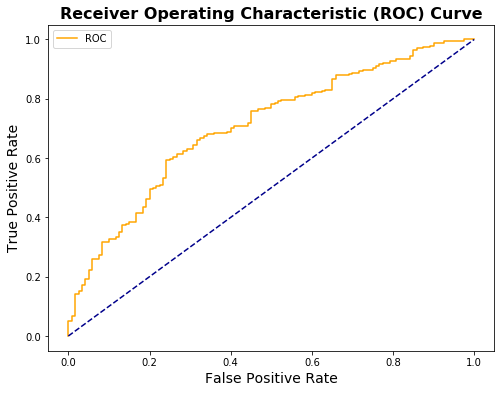

In [17]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [18]:
# Calculate area under ROC curve
m.roc_auc_score(test_y,y_pred)

0.575595238095238

The bigger the area covered (AUC), the better the machine learning model is at distinguishing the given classes. The ideal value for AUC being 1, our model is far from the best-case scenario since it is only 57.6% accurate for instances and their classifications. Our model's AUC is close to 0.5, which is when both the class distributions simply mimic each other (i.e. the model has no discrimination capabilities at all). However, since our AUC is slightly above 0.5, we can say that it does have some discrimination capabilities. In other words, it performs better than chance (50%), albeit slightly.
